In [1]:
import os
import pandas as pd
from math import ceil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML
import datetime
#pd.show_versions(as_json=False)

threshold = 1000

In [2]:
# Load Data
def load_raw(fn):
    datapath = os.path.join('../csse_covid_19_data/csse_covid_19_time_series/', fn)

    #datapath = '../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    
    raw = pd.read_csv(datapath)
    del raw['Lat']
    del raw['Long']
    raw= raw.replace('Mainland China','China')
    return raw

raw = load_raw('time_series_covid19_confirmed_global.csv')
#raw_deaths = load_raw('time_series_covid19_deaths_global.csv')

raw


,Province/State,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,18054,18969,19551,20342,20917,21459,22142,22890,23546,24102
1,NaN,Albania,0,0,0,0,0,0,0,0,...,1197,1212,1232,1246,1263,1299,1341,1385,1416,1464
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,9831,9935,10050,10154,10265,10382,10484,10589,10698,10810
3,NaN,Andorra,0,0,0,0,0,0,0,0,...,852,852,852,852,852,852,852,852,853,853
4,NaN,Angola,0,0,0,0,0,0,0,0,...,86,86,88,91,92,96,113,118,130,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,Sao Tome and Principe,0,0,0,0,0,0,0,0,...,485,499,499,513,513,514,611,632,639,659
262,NaN,Yemen,0,0,0,0,0,0,0,0,...,453,469,482,484,496,524,560,591,632,705
263,NaN,Comoros,0,0,0,0,0,0,0,0,...,132,132,141,141,141,141,162,162,163,176
264,NaN,Tajikistan,0,0,0,0,0,0,0,0,...,4289,4370,4453,4529,4609,4690,4763,4834,4902,4971


MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


group 0


MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


group 1


MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


group 2
done


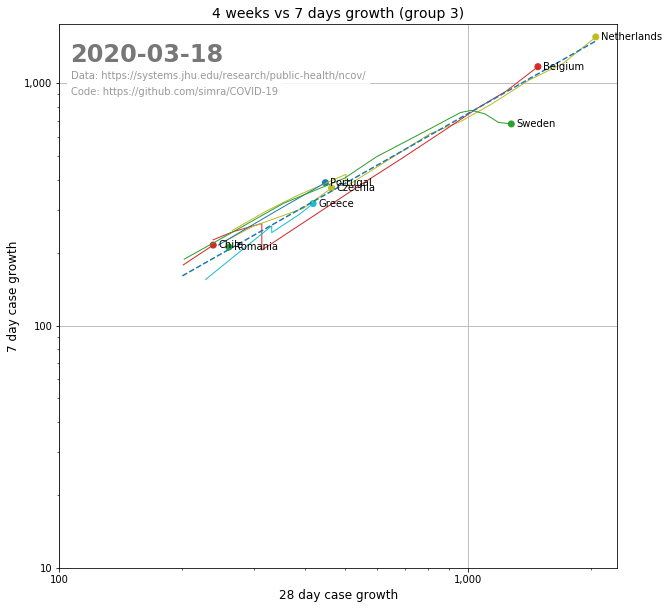

In [3]:
%matplotlib inline
from math import log
plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()


df=raw.groupby('Country/Region').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]

df = df[(df.index.isin(['Canada','Japan', 'Australia'])) | (df[last_date]>1000)]

df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
#del df['Cruise Ship']

wpp = pd.read_csv('../wpp/WPP2019_TotalPopulationBySex.csv')
wpp=wpp[(wpp['Time']==2020) & (wpp['Variant']=='Medium')]
wpp = dict(zip(wpp['Location'],wpp['PopTotal']))
wpp['Iran']=wpp['Iran (Islamic Republic of)']
wpp['US']=wpp['United States of America']
wpp['Korea, South']= wpp['Republic of Korea']
wpp['Russia'] = wpp['Russian Federation']

columnsFiltered = [c for c in df.columns if c in wpp and wpp[c]>=10000]
df = df[columnsFiltered]
#for c in df.columns:
#    df[c]=df[c]/wpp[c]
#print(df.columns)

def plot_ladder(date_tuple):
    (group,date)=date_tuple    
    growth = {}
    growth_l = {}
    points = []
    start = int(group*len(df.columns)/3)
    end = int((group+1)*len(df.columns)/3)
    columns = sorted(df.columns, key=lambda x:wpp[x], reverse=True)[start:end]
    #print(columns)
    filtered = df.loc[:date]
    maxDate=date
    markers = [item for sublist in ['oxds+*']*ceil(len(columns)/5) for item in sublist]    
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    colorsToUse=colors*ceil(len(columns)/len(colors))
    long_window= 4*7
    start = long_window
    ax.clear()
    for c,m,col in zip(columns,markers,colorsToUse):
        #growth[c] = [(pow(df[c][i]/max(1.0,df[c][i-6]),1.0/7)-1)*100 if df[c][i]>200 else float('nan') for i in range(20,len(df[c]))]
        growth[c] = [filtered[c][i]-filtered[c][i-6] if (filtered[c][i]>200 and filtered[c][i]>filtered[c][i-6]) else float('nan') for i in range(start,len(filtered[c]))]
        growth_l[c] = [filtered[c][i]-filtered[c][i-long_window] if (filtered[c][i]>200 and filtered[c][i]>filtered[c][i-long_window]) else float('nan') for i in range(start,len(filtered[c]))]
        #growth[c] = [growth[c][i] if growth[c][i]<100 else float('nan') for i in range(len(growth[c]))]
        ax.plot(growth_l[c][-14:], growth[c][-14:], linewidth=1,color=col)
        points.append([growth_l[c][-1],growth[c][-1],c])

    ax.scatter([p[0] for p in points],[p[1] for p in points],color=colorsToUse[:len(points)])   
    for (x,y,txt) in points:
        ax.annotate(txt,(x,y), xytext=(5,0), va='center', textcoords='offset points')
    font = font_manager.FontProperties(family='sans-serif',
                                       weight='normal',
                                       style='normal', size=12)

    from math import log10 as log
    x = [log(growth_l[c][-1]) if growth_l[c][-1]>0 else 0 for c in growth]
    y = [log(growth[c][-1]) if growth[c][-1]>0 else 0 for c in growth]
    #print(x,y)
    try:
        model = np.polyfit(x,y,1)
        model
        model_x = np.array([[log(200),1],[max(x),1]])
        model_y = np.power(10,model_x.dot(model))
        #print(model_x,model_y)
        ax.plot(np.power(10,model_x[:,0]), model_y, linestyle='--')
    except:
        print(x,y,date)
    ax.grid()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.get_xaxis().set_major_formatter(
        ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.get_yaxis().set_major_formatter(
        ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    #ax.yaxis.set_label_position("right")
    #ax.set_ylim([0,50])
    ax.set_xlabel('28 day case growth', size=12)
    ax.set_ylabel('7 day case growth', size=12)
    ax.set_title('4 weeks vs 7 days growth (group {})'.format(group+1), size=14)
    lims=ax.get_ylim()
    ax.set_ylim([10,lims[1]])
    lims=ax.get_xlim()
    ax.set_xlim([100,lims[1]])
    
#ax.legend(df.columns, prop=font)    
#plt.ylim((0,100))
    ax.text(0.02, 0.93, date.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='left', weight=800)
    ax.text(0.02, 0.90, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='left', size=10,
            color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    ax.text(0.02, 0.87, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='left', size=10,
            color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    #save_figure(maxDate,'10_c_{}_countvsgrowth_8week.png'.format(i))


#def plot_map(date_tuple):
#    c,dt = date_tuple
#    ax.clear()
#    ax.scatter(x,y, c=c, alpha=0.5, cmap='autumn_r')
#    ax.set_yticks([])
#    ax.set_xticks([])
#    plt.box(False)
#    ax.text(0.95, 0.1, dt, transform=ax.transAxes, color='#222222', size=24, ha='right', weight=800)
window=56
dates = df.index[window:]
#print(df.index)

for g in range(3):
    print('group {}'.format(g))
    frames = list(zip([g]*len(dates),dates))
    animator = animation.FuncAnimation(fig, plot_ladder, frames=frames, repeat=False)
    #HTML(animator.to_jshtml()) 
    #animator.save('data/ladder-{}-{}.gif'.format(g, max(df.index).strftime('%Y%m%d')))
    animator.save('data/ladder-{}-latest.gif'.format(g, max(df.index)))
print('done')